In [17]:
import json
import os
import pandas as pd
import numpy as np
from enum import Enum
import copy

from math import ceil
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa import stattools

In [18]:
font_size = 16
# plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': font_size, 
                     'axes.edgecolor': 'white',
                     'axes.grid': True})

colorscale = px.colors.qualitative.Dark24
pio.templates.default = "plotly_white"

In [19]:
class Apis(str, Enum):
    OPEN_SENSE_MAP = "2889936e-8e2d-11ee-b9d1-0242ac120002"
    SENSOR_COMMUNITY = "017f12f5-8acb-4531-ab77-0e5208a31bca"
    TELRAAM = "8c9a8f25-e54e-4884-aee6-a4529c5424ba"

out_dir = "./all_out"

# Overview

If I understood correctly, Telraam provides a camera that can pick up pedestrians, cars, bikes and so on to monitor traffic on a street. The free api provided is not what I expected, there is an endpoint that gives current data, that current data is the data of the last hour. So no matter how many queries there is no difference for queries made with a smaller interval then 1h.

In [20]:
t_df = pd.DataFrame(columns=[
    "timesent", "segment_id", "date", "uptime",
    "heavy", "car", "bike", "pedestrian", "v85"
])

codes = set()

dirs = os.listdir(out_dir)
for dir in dirs:
    if dir == Apis.TELRAAM:
        for file in os.listdir(f"{out_dir}/{dir}"):
            with open(f"{out_dir}/{dir}/{file}") as f:
                request = json.loads(f.read())
                body = request["body"]
                all_data = []
                codes.add(body["status_code"])
                for record in body["features"]:
                    data = {}
                    data["timesent"] = request["timeSent"]
                    data["segment_id"] = record["properties"]["segment_id"]
                    data["date"] = record["properties"]["date"]
                    data["uptime"] = record["properties"]["uptime"]
                    data["heavy"] = record["properties"]["heavy"]
                    data["car"] = record["properties"]["car"]
                    data["bike"] = record["properties"]["bike"]
                    data["pedestrian"] = record["properties"]["pedestrian"]
                    data["v85"] = record["properties"]["v85"]
                    all_data.append(data)
                t_df = pd.concat(
                    [t_df, pd.DataFrame(all_data)],
                    ignore_index=True
                )

t_df.head()

,timesent,segment_id,date,uptime,heavy,car,bike,pedestrian,v85
0,2023-12-07T12:19:05.49522,9000001661,2023-12-07 09:00:00+00:00,0.785,16.609072,68.52085,22.702605,6.367969,30.5
1,2023-12-07T12:19:05.49522,9000001786,2023-12-07 09:00:00+00:00,0.778611,142.5122,577.565508,46.092836,35.946411,38.5
2,2023-12-07T12:19:05.49522,9000001833,,,,,,,
3,2023-12-07T12:19:05.49522,9000002074,2023-12-07 09:00:00+00:00,0.763056,24.812061,675.418732,86.413775,87.809622,27.5
4,2023-12-07T12:19:05.49522,9000002109,2023-12-07 09:00:00+00:00,0.791944,0.0,1.256983,3.844769,3.781527,16.5


In [21]:
telraam = copy.deepcopy(t_df)
telraam = telraam.set_index(["timesent", "segment_id", "date"])
telraam = telraam.drop_duplicates()

In [22]:
def describe(df):
    general_stats = df.describe().T
    general_stats = general_stats.sort_index()
    delete_cols = ['25%', '50%', '75%']
    general_stats = general_stats.drop(delete_cols, axis=1)
    
    #general_stats = general_stats.rename({'count': 'perc missing'}, axis=1)
    
    styled_general_stats = general_stats.style.background_gradient(cmap='Blues', axis=None, subset=['count',])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Greens', axis=None, subset=['mean',])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Reds', axis=None, subset=['std',])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Purples', axis=None, subset=['min',])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Greys', axis=None, subset=['max',])
    return styled_general_stats.format({
            'perc missing' : '{:,.2f}', 
            'mean' : '{:.2f}',
            'std' : '{:.2f}', 
            'min' : '{:.2f}',
            'max' : '{:.2f}'
    })

In [23]:
telraam_clean = telraam.drop(["uptime"], axis=1).fillna(0).replace('', 0).astype(float)
describe(telraam_clean)

,count,mean,std,min,max
bike,565.000000,46.27,43.58,0.00,308.34
car,565.000000,226.05,235.46,0.00,1280.98
heavy,565.000000,72.03,95.46,0.00,630.57
pedestrian,565.000000,32.04,32.56,0.00,218.16
v85,565.000000,29.18,10.91,0.00,89.50


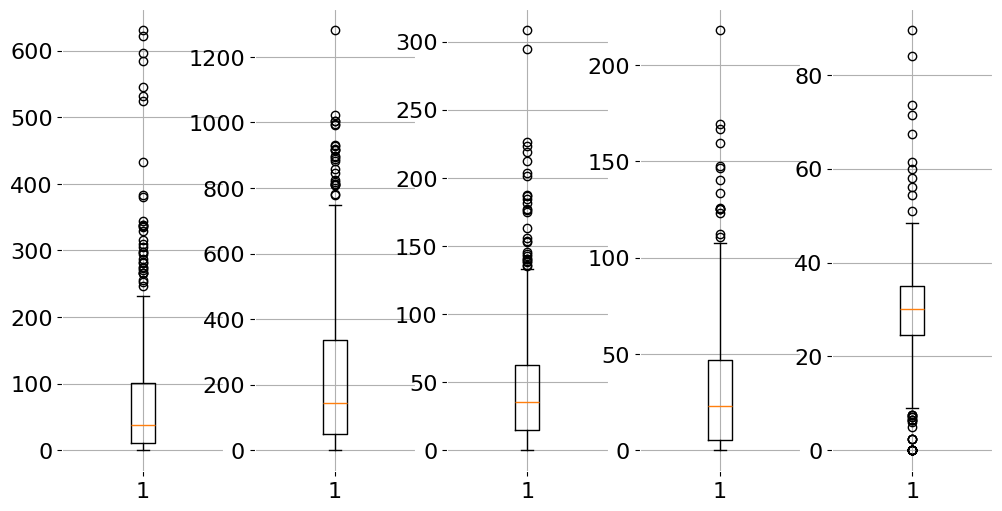

In [24]:
fig, boxplots = plt.subplots(1,len(telraam_clean.columns), figsize=(12, 6))
for ax, col in zip(boxplots, telraam_clean.columns):
    ax.boxplot(telraam_clean[col])
plt.show()

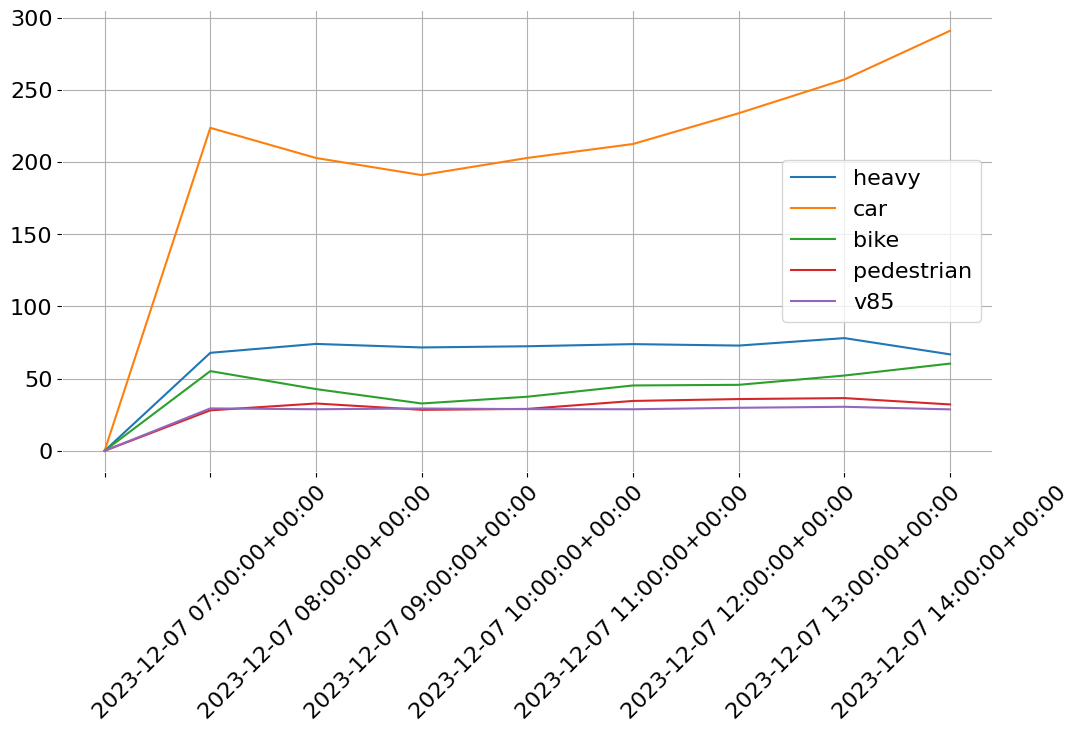

In [70]:
"""
first_filter = telraam_clean[np.in1d(telraam_clean.index.get_level_values(1), [9000001661])]
first_filter[np.in1d(first_filter.index.get_level_values(0), ['2023-12-07T14:44:05.478034'])]
"""
fig, timeseries = plt.subplots(1,1, figsize=(12, 6))
grouped = telraam_clean.groupby(level=(2)).mean()
for col in grouped.columns:
    timeseries.plot(grouped.index, grouped[col], label=col)

plt.legend()
plt.xticks(rotation=45)
plt.show()